# Tutorial Notebook for nisarhdf.nisarROFFHDF
---

This notebook demonstrates the functionality of `nisarROFFHDF`, which is at tool for reading NISAR **ROFF** products.  Some of its functionality is specifically developed for the Greenland Mapping Project (GrIMP) workflows, but it may also be of general use for working with these products. If nothing else, the source code provides examples of how to unpack these projects.

## Installation

The easiest way to ensure the code works is to create a custom environment using the *environment.yml* file included in this *nisarhdf* repository. To do so execute the following,

`conda env create -f environment.yml`

Then setup the kernel for the Jupyter notebooks with the command:

`python -m ipykernel install --user --name=nisarcryo`

Then activate the environment:

`conda activate nisarcryo`

Finally, start Jupyter and open the notebooks.

**Even if you want to work with your existing environment, the *environment.yml* file demonstrates which packages must be installed if they are not already present.**


## Python Imports

In [1]:
%load_ext autoreload
%autoreload 2
import nisarhdf
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray
import getpass
import os

In [2]:
if not os.path.exists('./output'):
    os.mkdir('./output')

## Open the HDF

Edit the path below to point to the ROFF product you wish to work with.

In [3]:
if getpass.getuser() in ['jovyan']:
    ROFFFile  = 's3://nisar-st-data-ondemand/ALOS-2-data/INSAR/cryo_sample_products_092024/frame_280/insar_products/ROFF_ALOS2496725280-230804_ALOS2498795280-230818.h5'
else:
    ROFFFile = '/Volumes/insar1/ian/NISAR/frame_280/insar/products/ROFF_ALOS2496725280-230804_ALOS2498795280-230818.h5' # Modify to local file path
print(ROFFFile)

s3://nisar-st-data-ondemand/ALOS-2-data/INSAR/cryo_sample_products_092024/frame_280/insar_products/ROFF_ALOS2496725280-230804_ALOS2498795280-230818.h5


Create an instance and open the hdf as shown below. For normal products, you shouldn't have to specify the orbit, but while the orbit fields are present in the example file, they are not populated. When you open the hdf, you can specify the precise orbit XMLs if desired, which are release a few weeks after the MOI orbits used in the processing.

In [23]:
%%time
myROFF = nisarhdf.nisarROFFHDF()
myROFF.openHDF(ROFFFile , referenceOrbitXML=None, secondaryOrbitXML=None,
               referenceOrbit=49672, secondaryOrbit=49879)

ROFF referenceZeroDopplerStartTime
CPU times: user 781 ms, sys: 155 ms, total: 936 ms
Wall time: 2.91 s


## ROFF Parameters

A summary of some of the more important parameters for the **ROFF** products can be obtained by.

In [5]:
myROFF.printParams()

ROFF.referenceOrbit = 49672 
ROFF.frame = 0 
ROFF.datetime = 2023-08-04 14:57:47.166045 
ROFF.referenceGranule = rslc_ALOS2496725280-230804.h5 
ROFF.SLCNearRange = 814637.0 
ROFF.SLCFarRange = 852284.282920905 
ROFF.SLCFirstZeroDopplerTime = 53867.166045 
ROFF.SLCLastZeroDopplerTime = 53877.165933569675 
ROFF.secondaryOrbit = 49879 
ROFF.secondaryDatetime = 2023-08-18 14:57:47.171967 
ROFF.secondaryGranule = rslc_ALOS2498795280-230818.h5 
ROFF.LookDirection = right 
ROFF.PassType = descending 
ROFF.Wavelength = 0.23840349999999996 
ROFF.PRF = 3051.234 
ROFF.epsg = 3031 
ROFF.r0 = 266 
ROFF.a0 = 266 
ROFF.deltaR = 30 
ROFF.deltaA = 15 
ROFF.OffsetRangeSize = 857 
ROFF.OffsetAzimuthSize = 1996 
ROFF.OffsetRangePixelSize = 42.91266718443529 
ROFF.OffsetAzimuthPixelSize = 34.07459178586952 
ROFF.OffsetZeroDopplerTimeSpacing = 0.004916043803916711 
ROFF.OffsetNearRange = 815017.492315702 
ROFF.OffsetFirstZeroDopplerTime = 53867.25322284346 
ROFF.OffsetIncidenceCenter = 39.840231013107314 



The coordinates of the offsets related to the reference SLC coordinates is given by:

In [6]:
print(f'Origin in SLC pixels Range {myROFF.r0} Along Track {myROFF.a0}')
print(f'Offset spacing in SLC pixels Range {myROFF.deltaR} Along Track {myROFF.deltaA}')
print(f'Number of Offsets in Range {myROFF.OffsetRangeSize} Along Track {myROFF.OffsetAzimuthSize}')

Origin in SLC pixels Range 266 Along Track 266
Offset spacing in SLC pixels Range 30 Along Track 15
Number of Offsets in Range 857 Along Track 1996


The offsets are calculated for three sets of window sizes (`slantRangeWindowSize` x `alongTrackWindowSize`), which are shifted $\pm$`slantRangeSearchWindowSize` by $\pm$`alongTrackWindowSize` in a large window to perform the correlation. These parameters for each layer are given by:

## Extract the Layers

For each of the 3 search window combinations, the matcher determines the `slantRangeOffset`, `slantRangeOffsetVariance`, `alongTrackOffset`, `alongTrackOffsetVariance`, `crossOffsetVariance`, `correlationSurfacePeak`, and `snr`. Each variable is save as 3xRangeSizexAzimuthSize numpy array. The following code displays the these fields for `layer2`.

In [7]:
fields = myROFF.dataFields
cbarExtend = ['both', 'max', 'both', 'max', 'max', 'max', 'max']

slantRangeOffset
slantRangeOffsetVariance
alongTrackOffset
alongTrackOffsetVariance
crossOffsetVariance
correlationSurfacePeak
snr


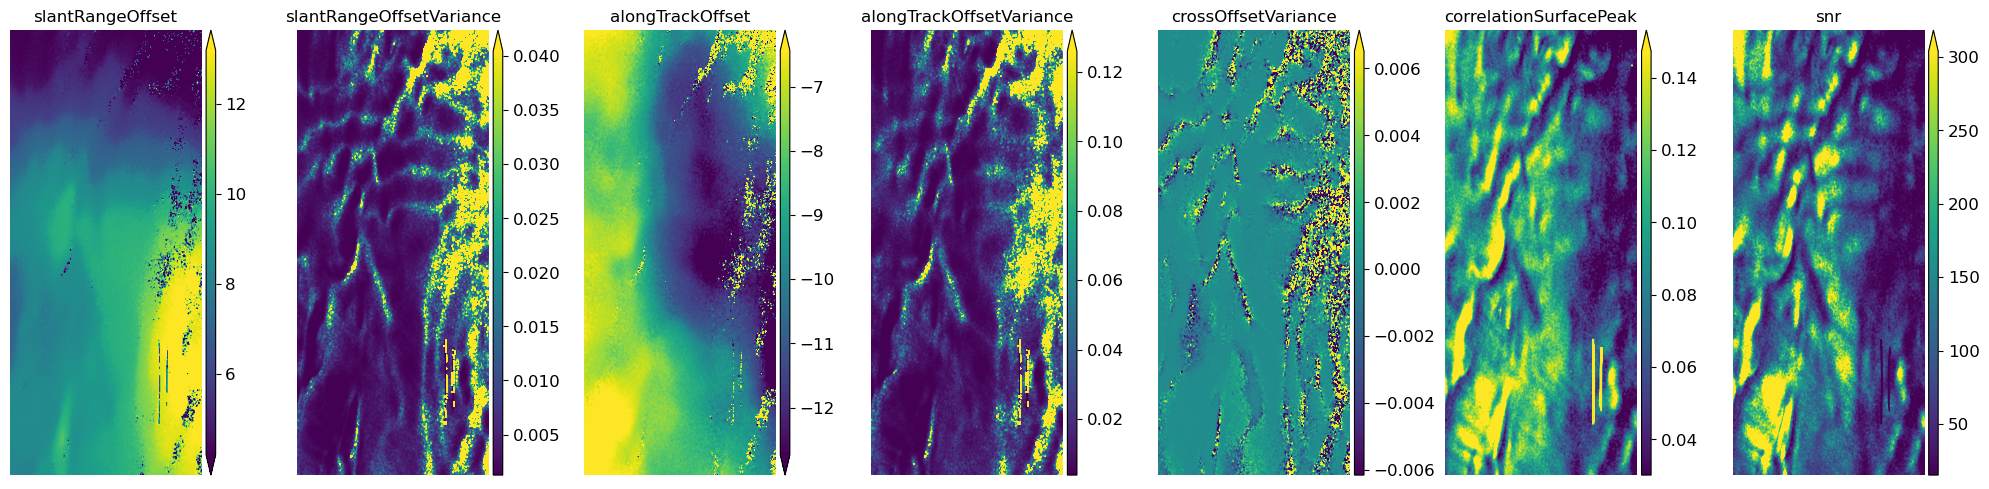

In [8]:
fig, axes = plt.subplots(1, 7, figsize=(20, 5))
layer = 3
for field, ax, cbE in zip(fields, axes, cbarExtend):
    # Extract the data for each field, but skip the DEM
    if field == 'digitalElevationModel':
        continue
    print(field)
    data = np.squeeze(getattr(myROFF, field)[layer-1])
    # threshold at top and bottom 5%
    vmin, vmax = nisarhdf.autoScaleRange(data, 95)
    h = ax.imshow(data, vmin=vmin, vmax=vmax, origin='lower')
    nisarhdf.colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend=cbE)
    ax.set_title(field)
    ax.axis('off')
fig.tight_layout()

## Remove outliers

Outliers can be remove by thresholding on the various fields. Note only outliers for the offsets are removed (all statistics are retained). For example to threshold by `correlationSurfacePeak` for all layers with layter dependent thresholds:

In [9]:
myROFF.removeOutlierOffsets('correlationSurfacePeak', thresholds=[0.07, 0.06, 0.025], layers=[1, 2, 3])

In this example, we could have used `snr` instead of `correlationPeak`. As the figure above indicates, these two metrics are similar in characters. As a result, empirically determining the appropriate threshold is more important than which metric is actually used.

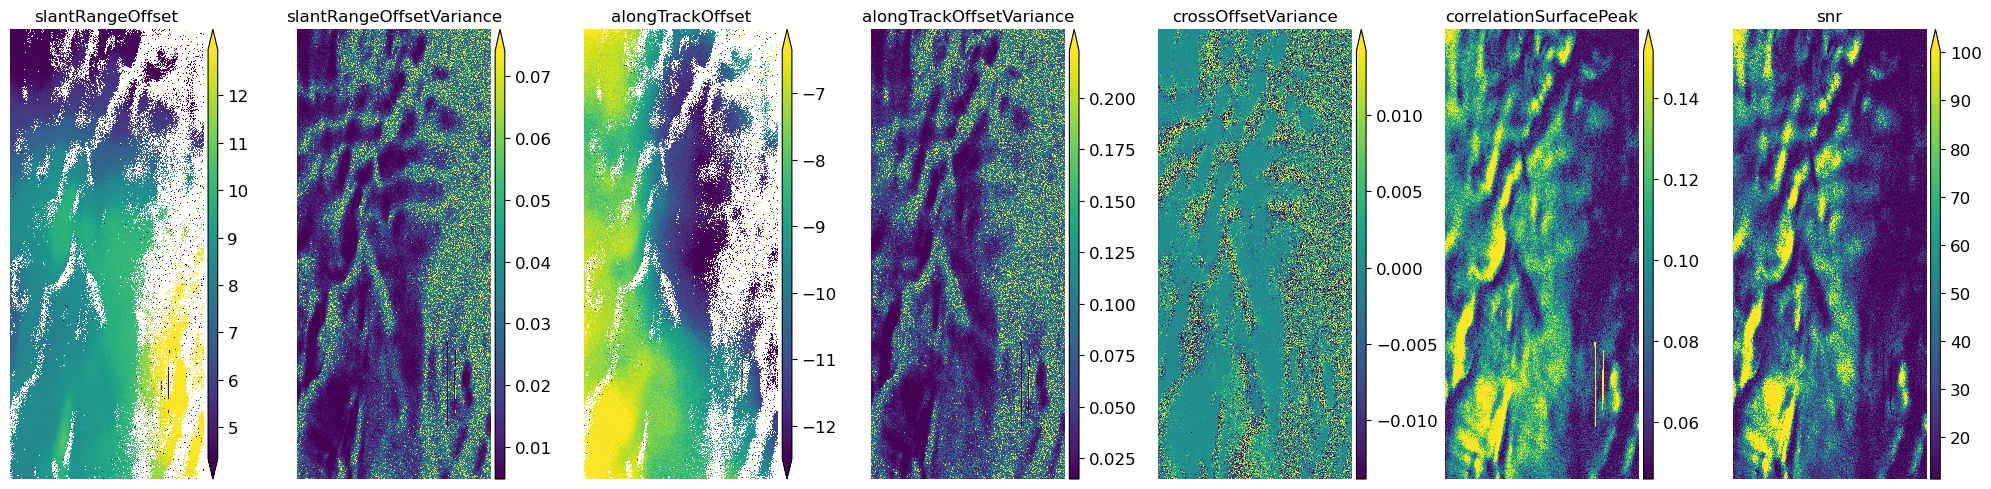

In [10]:
fig, axes = plt.subplots(1, 7, figsize=(20, 5))
layer = 2
for field, ax, cbE in zip(fields, axes, cbarExtend):
    # Extract the data for each field
    data = np.squeeze(getattr(myROFF, field)[layer-1])
    # threshold at top and bottom 5%
    vmin, vmax = nisarhdf.autoScaleRange(data, 95)
    h = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='none', origin='lower')
    nisarhdf.colorBar(h, ax, '', 'right', '5%',.05, 12, 12, extend=cbE)
    ax.set_title(field)
    ax.axis('off')
fig.tight_layout()

## Metadata Interpolation

Much of the spatially dependent information (e.g., incidenceAngle) is stored at meta data cubes (see nisar documenation). These cubes can be interpolatated to obtain the slantRange, alongTrack, and elevation dependent results. Here are examples of how to extract these data for the offset grids.

In each case, an interpolator is setup. Once the setup has occurred, you can interpolated `myROFF.interpolatorCubeName([[z, zeroDopplerTime, slantRange]])`. Interpolating to a grid can be acomplished by `myROFF.interpGrid(myROFF.interpolatorCubeName, zGrid, zeroDopplerGrid, slantRangeGrid)`.

**Note for speed when they are not needed, most of the interpolators and grids need to be explicitly initialized before use as shown below**

### Setup Grid for the Offsets

The R/D products include the DEM, which can be extracted as:

In this step a range/Dopper grid corresponding to the offset maps is created. For this plot, we include the zero Doppler and slant range coordinates. Since the product is storted as increasing with time, the parameter `origin='lower'` is used. As a result, the extent for the lower-left corner is set to `extent=myRUNW.extentLL`.

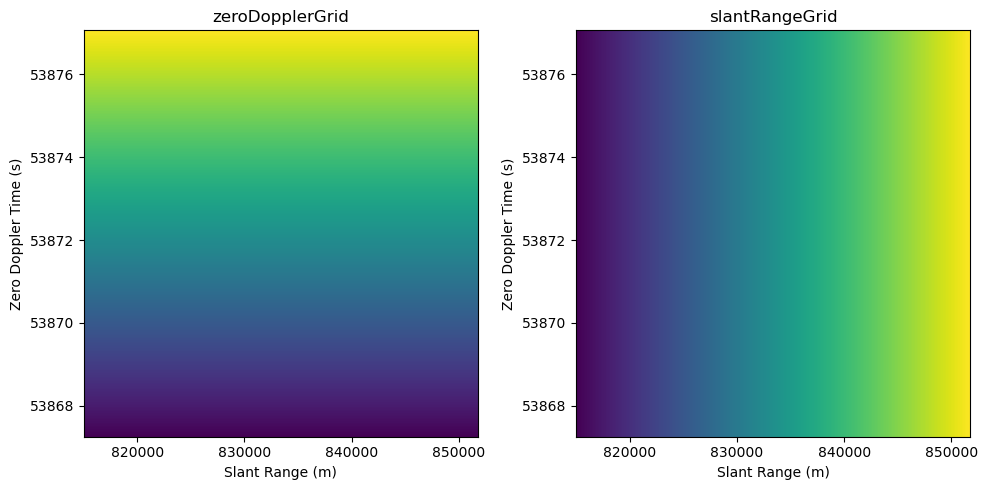

In [11]:
myROFF.setupRangeDopplerGrid()
z = np.zeros(myROFF.slantRangeGrid.shape)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(myROFF.zeroDopplerGrid, origin='lower', extent=myROFF.extentLL, aspect='auto')
axes[1].imshow(myROFF.slantRangeGrid, origin='lower', extent=myROFF.extentLL, aspect='auto')
for ax, field in zip(axes, ['zeroDopplerGrid', 'slantRangeGrid']):
    ax.locator_params(axis='x', nbins=4)
    ax.set_title(field)
    ax.set_xlabel('Slant Range (m)')
    ax.set_ylabel('Zero Doppler Time (s)')
fig.tight_layout()

### Incidence and Elevation Angles

The incidence and elevation angles can be computed as follows:

incidenceAngle min/max: 37.994 41.548
elevationAngle min/max: 33.918 36.957


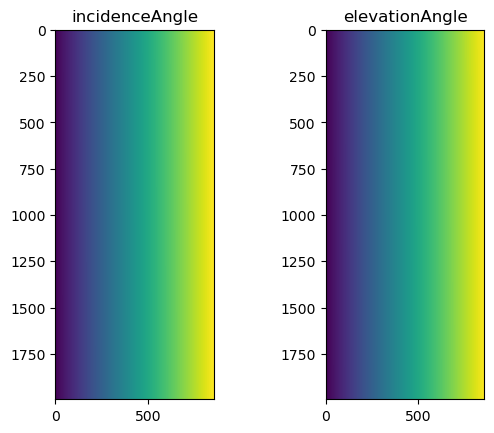

In [12]:
incidenceAngle = myROFF.incidenceAngleCube(myROFF.slantRangeGrid, myROFF.zeroDopplerGrid, z)
elevationAngle = myROFF.elevationAngleCube(myROFF.slantRangeGrid, myROFF.zeroDopplerGrid, z)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [incidenceAngle, elevationAngle], ['incidenceAngle', 'elevationAngle']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Ground Track Velocity

The ground track velocty is found by:

groundTrackVelocity min/max: 6860.042 6864.792


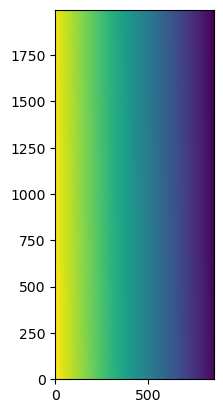

In [13]:
groundTrackVelocity=  myROFF.groundTrackVelocityCube(myROFF.slantRangeGrid, myROFF.zeroDopplerGrid, z)
fig, ax = plt.subplots(1,1)
ax.imshow(groundTrackVelocity, origin='lower')
print(f'groundTrackVelocity min/max: {np.min(groundTrackVelocity):.3f} {np.max(groundTrackVelocity):.3f}')

### XY Values in the Projected Coordinate System

The `x` and `y` coordinate at corresponding to each slantRange and zeroDopplerTime coordiantes can be determined as:

$X_{3031}$ Grid min/max: -1453427.295 -1366062.091
$Y_{3031}$ Grid min/max: -509232.752 -421686.868


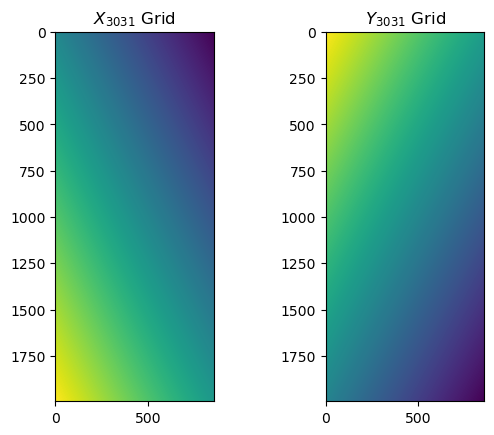

In [14]:
x, y =  myROFF.xyCube(myROFF.slantRangeGrid, myROFF.zeroDopplerGrid, z)

fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [x, y], [f'$X_{{{myROFF.epsg}}}$ Grid',f'$Y_{{{myROFF.epsg}}}$ Grid']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

## Baseline Components

The perpendicular and parallel baseline components are computed as follows:

bn min/max: 91.163 96.556
bp min/max: 74.619 76.365


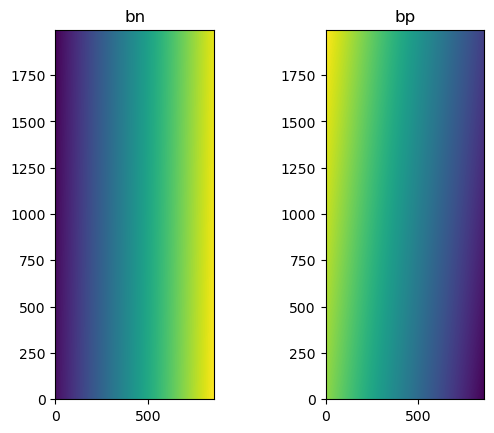

In [15]:
bn, bp =  myROFF.baselineCube(myROFF.slantRangeGrid, myROFF.zeroDopplerGrid, z)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [bn, bp], ['bn', 'bp']):
    ax.imshow(var, origin='lower')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Along Track Unit Vector and LOS Unit Vector

The x and y components of the line-of-sight and along-track unit vector can be determined on the offset grid by:

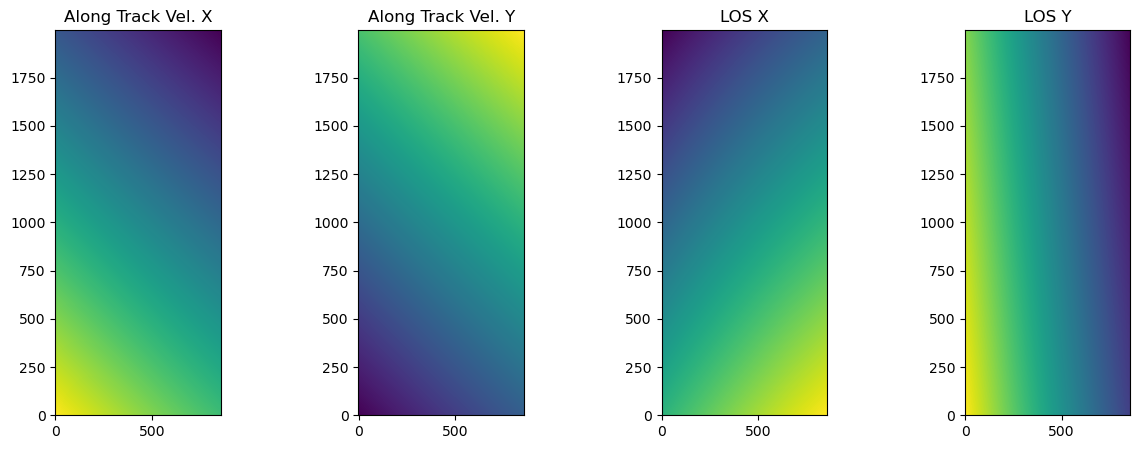

In [16]:
ATx, ATy =  myROFF.alongTrackUnitVectorCube(myROFF.slantRangeGrid, myROFF.zeroDopplerGrid, z)
LOSx, LOSy=  myROFF.losUnitVectorCube(myROFF.slantRangeGrid, myROFF.zeroDopplerGrid, z)
#
fig, axes = plt.subplots(1, 4, figsize=(15,5))
for ax, var, title in zip(axes.flatten(), [ATx, ATy, LOSx, LOSy], ['Along Track Vel. X', 'Along Track Vel. Y', 'LOS X', 'LOS Y']):
    ax.imshow(var, origin='lower')
    ax.set_title(title)

## Other Meta Data

Most of the essential meta data has been parsed and demonstrated in the examples above. Other quantities can be extracted by keyword from the h5 files. For example, the **centerFrequency** can be extracted as:

In [17]:
np.array(myROFF.h5['ROFF']['swaths']['frequencyA']['centerFrequency']).item()

1257500238.0418074

Note in the above example, `h5` has bypassed the `science` and `LSAR` levels for brevity. To access the h5 object from the the top, use `myROFF.h5Full`. See the NISAR documentation or open the the h5 file with a viewer to see all of the data in contains. 

## Save Data to Binary or Tiff Files.


The offsets can all be saved to flat binary files with a corresponding `.vrt` for each layer. In this example, the results are stored as tiff files.

In [18]:
myROFF.writeData('output/ROFFtiff', bands=['slantRangeOffset', 'alongTrackOffset', 'correlationSurfacePeak'], tiff=True)
!ls output/ROFFtiff*

output/ROFFtiff.layer1.cc.tif  output/ROFFtiff.layer2.dr.tif
output/ROFFtiff.layer1.da.tif  output/ROFFtiff.layer2.vrt
output/ROFFtiff.layer1.dr.tif  output/ROFFtiff.layer3.cc.tif
output/ROFFtiff.layer1.vrt     output/ROFFtiff.layer3.da.tif
output/ROFFtiff.layer2.cc.tif  output/ROFFtiff.layer3.dr.tif
output/ROFFtiff.layer2.da.tif  output/ROFFtiff.layer3.vrt


Note following tiff convention, the ROFF sets are stored with a geotransform that starts at the top left corner. The binary files are saved with the origin as the lower left corner.

## Read Saved Files

The data can be read back in as a `rioxarray`  using `nisarhdf.readVrtAsXarray`, which saves each band as a named data variable. The results can be displayed using the `xarray` version of `imshow`.

<xarray.Dataset> Size: 21MB
Dimensions:                 (x: 857, y: 1996)
Coordinates:
  * x                       (x) float64 7kB 8.15e+05 8.151e+05 ... 8.518e+05
  * y                       (y) float64 16kB 5.388e+04 5.388e+04 ... 5.387e+04
    spatial_ref             int64 8B 0
Data variables:
    slantRangeOffset        (y, x) float32 7MB 4.18 4.157 4.18 ... nan nan nan
    alongTrackOffset        (y, x) float32 7MB -6.241 -6.293 -6.258 ... nan nan
    correlationSurfacePeak  (y, x) float32 7MB 0.1289 0.1276 ... 0.01464 0.02093
Attributes: (12/30)
    a0:                            266
    bands:                         ['slantRangeOffset', 'alongTrackOffset', '...
    ByteOrder:                     LSB
    datetime:                      2023-08-04 14:57:47.166045
    deltaA:                        15
    deltaR:                        30
    ...                            ...
    secondaryOrbit:                49879
    SLCFarRange:                   852284.282920905
    SLCFirstZeroDopplerTime:       53867.166045
    SLCLastZeroDopplerTime:        53877.165933569675
    SLCNearRange:                  814637.0
    Wavelength:                    0.23840349999999996

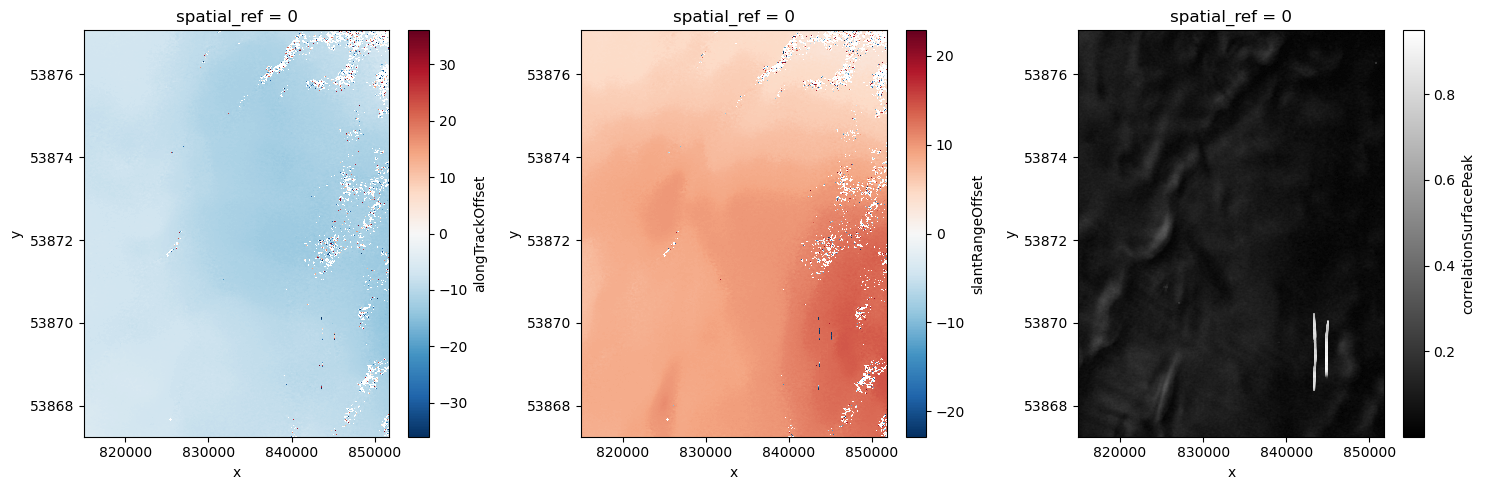

In [19]:
layer3 = nisarhdf.readVrtAsXarray('output/ROFFtiff.layer3.vrt', mask_and_scale=True)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
layer3.alongTrackOffset.plot.imshow(ax=axes[0], interpolation='none')
layer3.slantRangeOffset.plot.imshow(ax=axes[1], cmap='RdBu_r')
layer3.correlationSurfacePeak.plot.imshow(ax=axes[2], cmap='gray')
fig.tight_layout()
layer3

## Save Gridded Data Cubes

The gridded data cubes can also be saved as either flat binary or as cloud-optimized geotiff (COG) files. In this case, use `save=True` to save the result internally, and then use `writeData` to save data the same way the other bands are saved. In the example below, the data are saved as COGs.

In [20]:
myROFF.baselineCube(myROFF.slantRangeGrid, myROFF.zeroDopplerGrid, z, save=True);
myROFF.writeData('output/ROFFbaseline',bands=['bn', 'bp'], tiff=True) # ', 'elevationAngle'

<xarray.Dataset> Size: 14MB
Dimensions:      (x: 857, y: 1996)
Coordinates:
  * x            (x) float64 7kB 8.15e+05 8.151e+05 ... 8.517e+05 8.518e+05
  * y            (y) float64 16kB 5.388e+04 5.388e+04 ... 5.387e+04 5.387e+04
    spatial_ref  int64 8B 0
Data variables:
    bn           (y, x) float32 7MB nan nan nan nan ... 96.54 96.54 96.55 96.56
    bp           (y, x) float32 7MB nan nan nan nan ... 74.62 74.62 74.62 74.62
Attributes: (12/30)
    a0:                            266
    bands:                         ['bn', 'bp']
    ByteOrder:                     LSB
    datetime:                      2023-08-04 14:57:47.166045
    deltaA:                        15
    deltaR:                        30
    ...                            ...
    secondaryOrbit:                49879
    SLCFarRange:                   852284.282920905
    SLCFirstZeroDopplerTime:       53867.166045
    SLCLastZeroDopplerTime:        53877.165933569675
    SLCNearRange:                  814637.0
    Wavelength:                    0.23840349999999996

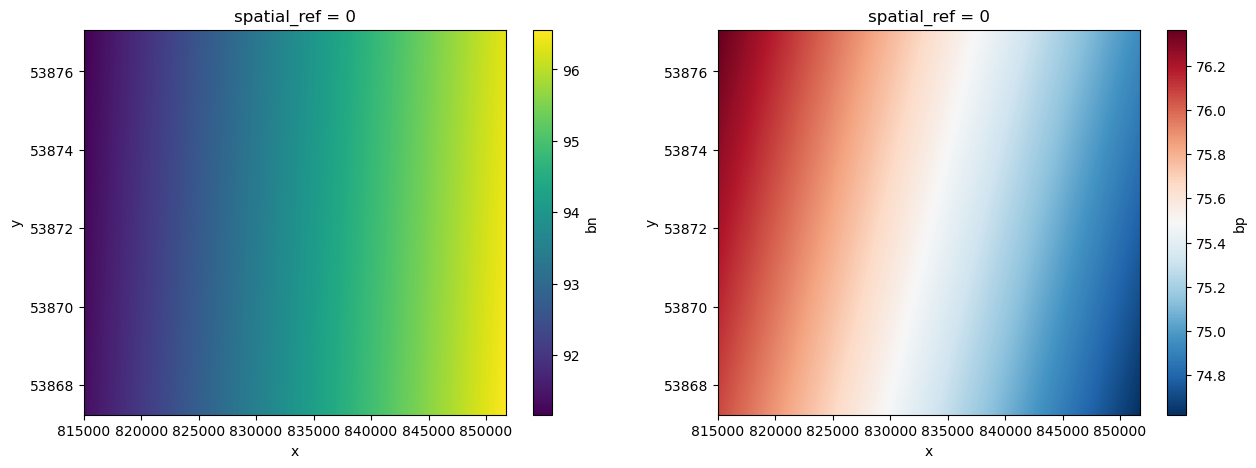

In [21]:
ROFFTiff = nisarhdf.readVrtAsXarray('output/ROFFbaseline.vrt', mask_and_scale=True)
#extent = [np.min(ROFFbinary.x), np.max(ROFFbinary.x), np.min(ROFFbinary.y), np.max(ROFFbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ROFFTiff.bn.plot.imshow(ax=axes[0])
ROFFTiff.bp.plot.imshow(ax=axes[1], cmap='RdBu_r')
ROFFTiff

## ANYTHING BELOW HERE IS DEBUGGING STUFF AND CAN BE IGNORED